# Yandex Cup 2020 Аналитика пробный раунд

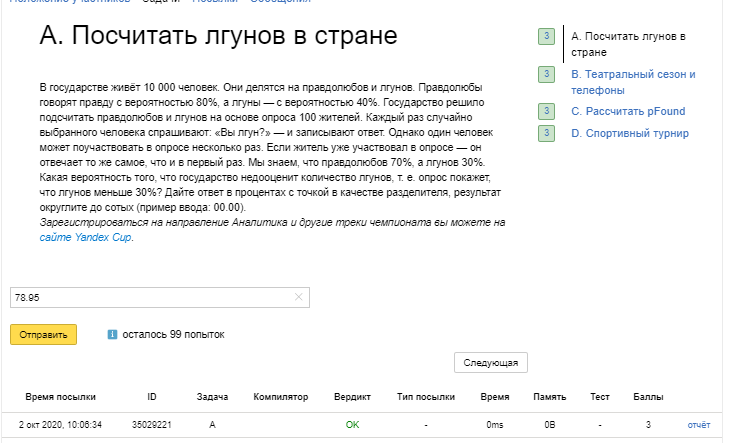

<p>На каждом шаге вероятность получить ответ «Да, я лгун» складывается из вероятности получить «Да, я лгун» от правдолюбов 
и вероятности получить «Да, я лгун» от лгунов.</p>
<p>Для правдолюбов:</p>
1й опрос: вероятность ответа «Да» от правдолюбов * доля правдолюбов = 0,2 * 0,7.
<p>Последующие опросы: вероятность ответа «Да» от правдолюбов * (доля правдолюбов – доля опрошенных правдолюбов) + вероятность ответа «Да» от правдолюбов * (доля опрошенных правдолюбов) = вероятность ответа «Да» от правдолюбов * доля правдолюбов = 0,2 * 0,7.
<p>Вероятность получить ответ «Да, я лгун» от правдолюбов составляет 0,14 и не зависит от того, сколько правдолюбов опросили до этого. аналогично для лгунов.</p>

In [28]:
#Вероятность, что респонденты ответят лгун
said_liar = (0.7*0.2+0.3*0.4)
print('Вероятность, что респонденты ответят "Я лгун":',said_liar)
# Количество лгунов, которое получит государство по результатам опроса, — это биномиальное распределение с параметрами n = 100, p = 0,26.
from scipy.stats import binom
prob = binom.cdf(k = 29, n = 100, p = said_liar)
prob

Вероятность, что респонденты ответят "Я лгун": 0.26


0.7894581274314292

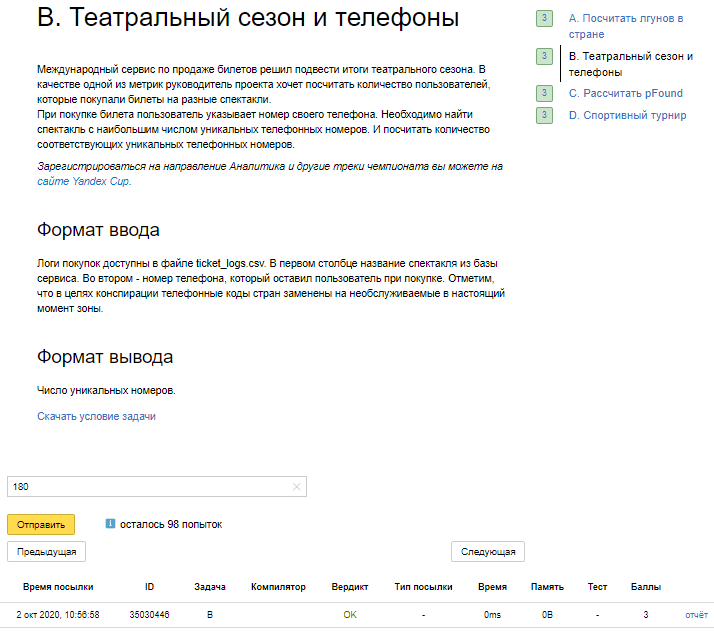

In [29]:
import pandas as pd
data = pd.read_csv(r'ticket_logs.csv',header = None,names = ['show','tel'])
#Очистка телефонных номеров
data['tel'] = data['tel'].str.replace('+','')
data['tel'] = data['tel'].str.replace('-','')
data['tel'] = data['tel'].str.replace('(','')
data['tel'] = data['tel'].str.replace(')','')
data['tel'] = data['tel'].str.lower()
data['tel'] = data['tel'].str.replace(' ','')
#Очистка названий спектаклей
data['show'] = data['show'].str.lower()
data['show'] = data['show'].str.strip()

data['len'] = data['tel'].str.len()
print('Уникальные длины очищенных тел номеров',data['len'].unique())
data['first_char'] = data['tel'].str[0]
print('С каких символов могут начинаться номера',data['first_char'].unique())
#Проверка на содержание букв в номерах
data['str_check'] = data['tel'].str.extract(r'([a-z]+)')
print(data[data['str_check'].isnull()!=True].head(2))

dict = {}
dict['A'] = 2
dict['B'] = 2
dict['C'] = 2
dict['D'] = 3
dict['E'] = 3
dict['F'] = 3
dict['G'] = 4
dict['H'] = 4
dict['I'] = 4
dict['J'] = 5
dict['K'] = 5
dict['L'] = 5
dict['M'] = 6
dict['N'] = 6
dict['O'] = 0
dict['P'] = 7
dict['Q'] = 0
dict['R'] = 7
dict['S'] = 7
dict['T'] = 8
dict['U'] = 8
dict['V'] = 8
dict['W'] = 9
dict['X'] = 9
dict['Y'] = 9
dict['Z'] = 9
dict

def translateNumber(phoneNumLetter):
    cleanNumber = ''
    for char in phoneNumLetter:
        if char.isalpha():
            cleanNumber += str(dict[char.upper()])
        if char.isdigit():
            cleanNumber += str(char)
    return cleanNumber
#Замена букв в номерах
data['tel_cleaned'] = [translateNumber(i) for i in data['tel']]
print('Самое большое кол-во уникальных тел номеров:',data.groupby('show')['tel_cleaned'].nunique().sort_values(ascending = False)[0])

Уникальные длины очищенных тел номеров [11]
С каких символов могут начинаться номера ['8']
                     show          tel  len first_char str_check
18  ночь перед рождеством  8803tonight   11          8   tonight
50                  норма  8806dollars   11          8   dollars
Самое большое кол-во уникальных тел номеров: 180


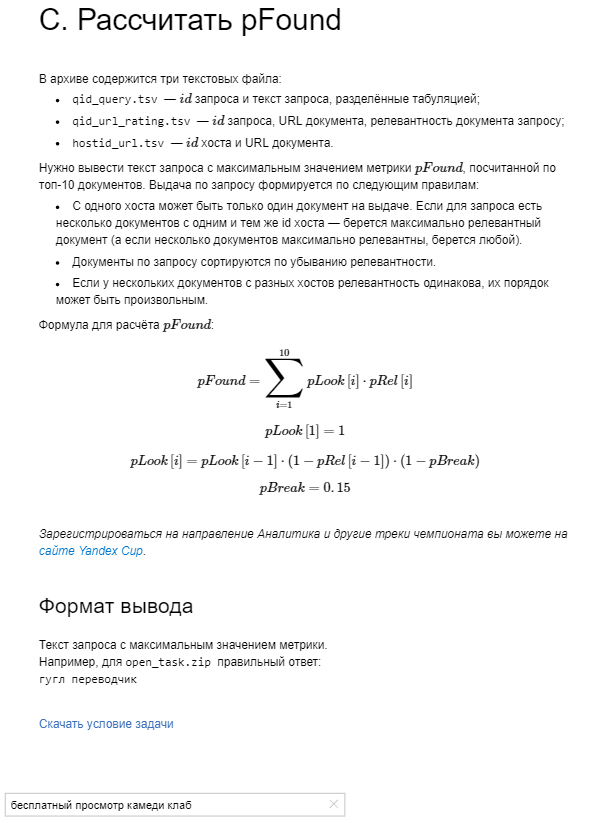

In [31]:
hostid_url = pd.read_csv(r'hostid_url.tsv', sep='\t',header = None,names = ['host_id','doc_url'])
qid_query = pd.read_csv(r'qid_query.tsv', sep='\t',header = None,names = ['id_reques','text'])
qid_url_rating = pd.read_csv(r'qid_url_rating.tsv', sep='\t',header = None,names = ['id_reques','doc_url','relevance'])
data1 = qid_url_rating.merge(qid_query,how = 'left',on = 'id_reques')
data2 = data1.merge(hostid_url, how = 'left', on ='doc_url')
# берем топ-10 урлов с наивысшим рейтингом
data2.groupby("host_id")["relevance"].max().sort_values(ascending=False)[:10].values
def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)

def pfound(group):
    # max рейтинг хоста
    max_by_host = group.groupby("host_id")["relevance"].max()
    # топ-10 url с max рейтингом
    top10 = max_by_host.sort_values(ascending=False)[:10] 
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
    return pfound
pfound(data2)
data2.loc[data2['id_reques']==data2.groupby('id_reques').apply(pfound).idxmax(),'text'].max()

'бесплатный просмотр камеди клаб'

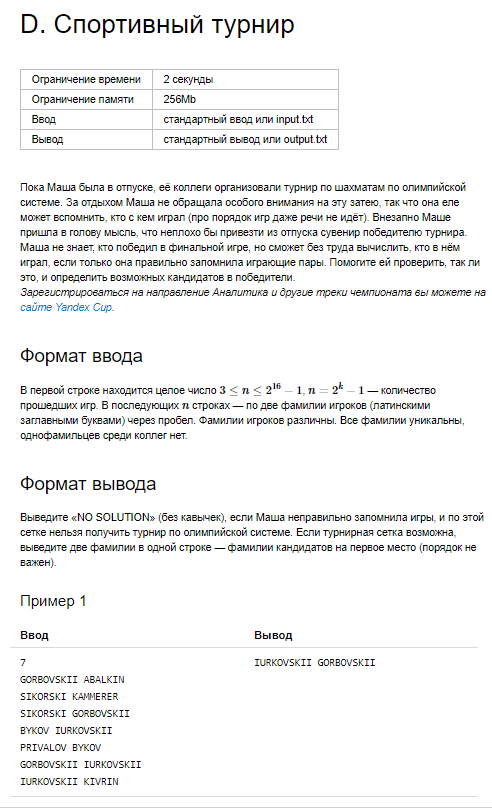

[Решение](https://habr.com/ru/company/yandex/blog/519846/)

In [17]:
import sys
import collections

def solve(fname):
    games = []
    for it, line in enumerate(open(fname)):
        line = line.strip()
        if not line:
            continue
        if it == 0:
            n_games = int(line)
            n_rounds = n_games.bit_length()
        else:
            games.append(line.split())
    return games,n_games,n_rounds
# Читаем из файла кол-во игр игры, рассчитываем кол-во раундов
games,n_games,n_rounds = solve( "input.txt")

#подсчет кол-ва сыгранных игр
gamer2games_cnt = collections.Counter()
#Участники раундов
rounds = [[] for _ in range(n_rounds + 1)]
for game in games:
    gamer_1, gamer_2 = game
    gamer2games_cnt[gamer_1] += 1
    gamer2games_cnt[gamer_2] += 1
#Участники раундов
ok = True
for game in games:
    gamer_1, gamer_2 = game
    game_round = min(gamer2games_cnt[gamer_1], gamer2games_cnt[gamer_2])
    if game_round > n_rounds:
        ok = False
        break
    rounds[game_round].append(game)
finalists = list((gamer for gamer, games_cnt in gamer2games_cnt.items() if games_cnt == n_rounds))
for cur_round in range(1, n_rounds):
    #Проверка кол-ва раундов
    if len(rounds[cur_round]) != pow(2, n_rounds - cur_round):
        ok = False
        break
    cur_round_gamers = set()
    #Состав участников в раудах уникальный
    for gamer_1, gamer_2 in rounds[cur_round]:
        if gamer_1 in cur_round_gamers or gamer_2 in cur_round_gamers:
            ok = False
            break
        cur_round_gamers.add(gamer_1)
        cur_round_gamers.add(gamer_2)

print (' '.join(finalists) if ok else 'NO SOLUTION')

GORBOVSKII IURKOVSKII
